# Xarray with Dask Arrays

In this notebook we show how to apply xarray operations on Dask DataArray objects.

- Open a dataset
- Use standard xarray operations
- Persist data in memory
- Custom workflows and automatic parallelisation

The following material uses Coupled Model Intercomparison Project (CMIP6) collections. The CMIP6 terms of use are found [here](https://pcmdi.llnl.gov/CMIP6/TermsOfUse/TermsOfUse6-1.html). 

-----

- Original Authors: NCI Virtual Research Environment Team
- Keywords: CMIP6, xarray, dask
- CreationDate: 2020-May
---
-  Adapted to DKRZ jupyterhub and data pool: S. Kindermann

In [1]:
%matplotlib inline

import dask
import xarray as xr

### Start Dask Client for Dashboard

Choose from the following two options to create a client:

In [2]:
# set the correct status link for dashboard
import dask
from dask.distributed import Client

dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})

In [3]:
from dask.distributed import Client
client = Client(n_workers=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/k202015/levante-spawner-preset//proxy/8787/status,
Dashboard: /user/k202015/levante-spawner-preset//proxy/8787/status,Workers: 4
Total threads: 24,Total memory: 20.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44059,Workers: 4
Dashboard: /user/k202015/levante-spawner-preset//proxy/8787/status,Total threads: 24
Started: Just now,Total memory: 20.00 GiB
Comm: tcp://127.0.0.1:42437,Total threads: 6
Dashboard: /user/k202015/levante-spawner-preset//proxy/38375/status,Memory: 5.00 GiB
Nanny: tcp://127.0.0.1:41889,


Starting the Dask Client will provide a dashboard which is useful to gain insight into the computation. The link to the dashboard will become visible when you create the Client. We recommend having the Client open on one side of your screen and your notebook open on the other side, which will be useful for learning purposes.

### Open a dataset

Xarray is an open source project and Python package that extends the labeled data functionality of Pandas to N-dimensional array-like datasets. It shares a similar API to NumPy and Pandas and supports both Dask and NumPy arrays under the hood. 

By specifying the chunk shape, xarray will automatically create Dask arrays for each data variable in the `Dataset`. In xarray, `Datasets` are dict-like containers of labelled arrays, analogous to the `pandas.DataFrame`. Note that we're taking advantage of xarray's dimension labels when specifying chunk shapes.

In [4]:
!ls /pool/data/CMIP6/data/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/6hrPlevPt/psl/gn/v20191108/*.nc

/pool/data/CMIP6/data/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/6hrPlevPt/psl/gn/v20191108/psl_6hrPlevPt_ACCESS-CM2_historical_r1i1p1f1_gn_195001010600-196001010000.nc
/pool/data/CMIP6/data/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/6hrPlevPt/psl/gn/v20191108/psl_6hrPlevPt_ACCESS-CM2_historical_r1i1p1f1_gn_196001010600-197001010000.nc
/pool/data/CMIP6/data/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/6hrPlevPt/psl/gn/v20191108/psl_6hrPlevPt_ACCESS-CM2_historical_r1i1p1f1_gn_197001010600-198001010000.nc
/pool/data/CMIP6/data/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/6hrPlevPt/psl/gn/v20191108/psl_6hrPlevPt_ACCESS-CM2_historical_r1i1p1f1_gn_198001010600-199001010000.nc
/pool/data/CMIP6/data/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/6hrPlevPt/psl/gn/v20191108/psl_6hrPlevPt_ACCESS-CM2_historical_r1i1p1f1_gn_199001010600-200001010000.nc
/pool/data/CMIP6/data/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/6hrPlevPt/psl/gn/v20191108/psl_6hrPlevPt_ACCESS-CM2_hi

In [5]:
# On DKRZ system
filename = '/pool/data/CMIP6/data/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/6hrPlevPt/psl/gn/v20191108/*.nc'
#filename = '/pool/data/CMIP6/data/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/6hrLevPt/psl/v20191108/gn/latest/*.nc'
ds = xr.open_mfdataset(filename,combine='nested', concat_dim='time',chunks={'lat': 144, 'lon': 92, 'time': -1})
ds = ds.sel(time=slice('1950','1951'))
ds

<xarray.Dataset>
Dimensions:   (time: 2919, lat: 144, bnds: 2, lon: 192)
Coordinates:
  * time      (time) datetime64[ns] 1950-01-01T06:00:00 ... 1951-12-31T18:00:00
  * lat       (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon       (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (time, lat, bnds) float64 dask.array<chunksize=(2919, 144, 2), meta=np.ndarray>
    lon_bnds  (time, lon, bnds) float64 dask.array<chunksize=(2919, 92, 2), meta=np.ndarray>
    psl       (time, lat, lon) float32 dask.array<chunksize=(2919, 144, 92), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2019-11-08T06:28:21Z
    ...                     ...
    variable_id:            psl
    variant_label:          r1i1p1f1
    version:                v20191108
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/2f5b09d6-488b-427f-adee-709bdf1592a8
    license:                CMIP6 model data produced by CSIRO is licensed un...

Quickly inspecting the `Dataset` above, we'll note that this `Dataset` has four _dimensions_ akin to axes in NumPy (`bnds`, `lat`, `lon`, and `time`), three _coordinate variables_ akin to `pandas.Index` objects (also named `lat`, `lon`, and `time`), and one data variable (`psl`) as well as two data varibles defining the lat and lon cell bounds (`lat_bnds`, `lon_bnds`). Xarray also holds Dataset specific metadata as _attributes_.

In [6]:
da = ds['psl']
da

<xarray.DataArray 'psl' (time: 2919, lat: 144, lon: 192)>
dask.array<getitem, shape=(2919, 144, 192), dtype=float32, chunksize=(2919, 144, 92), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01T06:00:00 ... 1951-12-31T18:00:00
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
Attributes:
    standard_name:  air_pressure_at_mean_sea_level
    long_name:      Sea Level Pressure
    comment:        Sea Level Pressure
    units:          Pa
    cell_methods:   area: mean time: point
    cell_measures:  area: areacella
    history:        2019-11-08T06:28:19Z altered by CMOR: replaced missing va...

Each data variable in xarray is called a `DataArray`. These are the fundemental labelled array object in xarray. Much like the `Dataset`, `DataArrays` also have _dimensions_ and _coordinates_ that support many of its label-based opperations.

In [7]:
da.data

dask.array<getitem, shape=(2919, 144, 192), dtype=float32, chunksize=(2919, 144, 92), chunktype=numpy.ndarray>

Accessing the underlying array of data is done via the `data` property. Here we can see that the Dask array is backed by a NumPy array of the actual values.

### Use Standard Xarray Operations

In almost all cases, operations using xarray objects are identical regardless of whether the underlying data is stored as a Dask array or a NumPy array.

In [8]:
da2 = da.groupby('time.month').mean('time')
da3 = da.groupby('time.month') - da2
da3

<xarray.DataArray 'psl' (time: 2919, lat: 144, lon: 192)>
dask.array<getitem, shape=(2919, 144, 192), dtype=float32, chunksize=(124, 144, 92), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01T06:00:00 ... 1951-12-31T18:00:00
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
    month    (time) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12 12

In [9]:
da3.data

dask.array<getitem, shape=(2919, 144, 192), dtype=float32, chunksize=(124, 144, 92), chunktype=numpy.ndarray>

Call `.compute()` or `.load()` when you want your result as an `xarray.DataArray` with data stored as NumPy arrays.

If you started `Client()` above then you may want to watch the status page during computation.

In [10]:
computed_da = da3.load()
type(computed_da.data)

numpy.ndarray

In [11]:
computed_da

<xarray.DataArray 'psl' (time: 2919, lat: 144, lon: 192)>
array([[[-1243.6094 , -1245.6172 , -1244.9531 , ..., -1244.3203 ,
         -1247.0625 , -1246.8438 ],
        [-1333.1016 , -1336.3828 , -1339.8281 , ..., -1328.875  ,
         -1330.5078 , -1332.4766 ],
        [-1338.6016 , -1339.9297 , -1337.6875 , ..., -1347.375  ,
         -1344.6797 , -1342.2969 ],
        ...,
        [  411.125  ,   409.76562,   408.2422 , ...,   414.3125 ,
           413.1953 ,   412.10938],
        [  442.28125,   441.91406,   441.5078 , ...,   442.67188,
           442.6172 ,   442.5703 ],
        [  454.03906,   454.1797 ,   454.26562, ...,   453.39844,
           453.6172 ,   453.8828 ]],

       [[-1216.1094 , -1216.6172 , -1215.2656 , ..., -1217.9453 ,
         -1217.9375 , -1218.0938 ],
        [-1289.1016 , -1290.5703 , -1290.8281 , ..., -1280.1875 ,
         -1284.2578 , -1287.7891 ],
        [-1298.4766 , -1303.2422 , -1301.4375 , ..., -1295.5    ,
         -1294.6797 , -1295.5469 ],
...
        [ 2241.3125 ,  2245.8594 ,  2250.8203 , ...,  2229.7734 ,
          2233.2344 ,  2237.1484 ],
        [ 2449.5469 ,  2452.7812 ,  2456.0547 , ...,  2440.5234 ,
          2443.4297 ,  2446.4844 ],
        [ 2574.414  ,  2575.4688 ,  2576.539  , ...,  2571.539  ,
          2572.5234 ,  2573.4453 ]],

       [[  964.78125,   962.7656 ,   963.34375, ...,   958.46875,
           961.2344 ,   963.7578 ],
        [ 1127.625  ,  1125.3047 ,  1122.7734 , ...,  1130.8516 ,
          1130.9062 ,  1129.2812 ],
        [ 1109.3125 ,  1104.3281 ,  1104.0078 , ...,  1130.5625 ,
          1130.3594 ,  1122.3125 ],
        ...,
        [ 2483.     ,  2483.8594 ,  2485.0078 , ...,  2481.3984 ,
          2481.7969 ,  2482.3984 ],
        [ 2655.4844 ,  2656.7812 ,  2657.9922 , ...,  2651.836  ,
          2653.0547 ,  2654.2969 ],
        [ 2746.664  ,  2747.3438 ,  2747.9766 , ...,  2744.8516 ,
          2745.5234 ,  2746.1328 ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01T06:00:00 ... 1951-12-31T18:00:00
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
    month    (time) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12 12

### Persist data in memory

If you have the available RAM for your dataset then you can persist data in memory.  

This allows future computations to be much faster.

In [12]:
da = da.persist()

### Time Series Operations

We want datetime index time-series operations to work efficiently. Here we demo the use of xarray's resample method:

In [13]:
da.resample(time='1D').mean('time')

<xarray.DataArray 'psl' (time: 730, lat: 144, lon: 192)>
dask.array<stack, shape=(730, 144, 192), dtype=float32, chunksize=(1, 144, 92), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 1951-12-31
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1

Apply a rolling window of 30 timesteps:

In [14]:
da_smooth = da.rolling(time=30).mean().persist()
da_smooth

<xarray.DataArray 'psl' (time: 2919, lat: 144, lon: 192)>
dask.array<truediv, shape=(2919, 144, 192), dtype=float64, chunksize=(2919, 144, 92), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01T06:00:00 ... 1951-12-31T18:00:00
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
Attributes:
    standard_name:  air_pressure_at_mean_sea_level
    long_name:      Sea Level Pressure
    comment:        Sea Level Pressure
    units:          Pa
    cell_methods:   area: mean time: point
    cell_measures:  area: areacella
    history:        2019-11-08T06:28:19Z altered by CMOR: replaced missing va...

Since xarray stores each of its coordinate variables in memory, slicing by label is trivial and entirely lazy.

In [15]:
%time da.sel(time='1950-01-01T18:00:00')

CPU times: user 2.22 ms, sys: 1.19 ms, total: 3.41 ms
Wall time: 5.74 ms


<xarray.DataArray 'psl' (lat: 144, lon: 192)>
dask.array<getitem, shape=(144, 192), dtype=float32, chunksize=(144, 92), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 1950-01-01T18:00:00
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
Attributes:
    standard_name:  air_pressure_at_mean_sea_level
    long_name:      Sea Level Pressure
    comment:        Sea Level Pressure
    units:          Pa
    cell_methods:   area: mean time: point
    cell_measures:  area: areacella
    history:        2019-11-08T06:28:19Z altered by CMOR: replaced missing va...

In [16]:
%time da.sel(time='1950-01-01T18:00:00').load()

CPU times: user 10 ms, sys: 1.96 ms, total: 12 ms
Wall time: 12.9 ms


<xarray.DataArray 'psl' (lat: 144, lon: 192)>
array([[ 98951.   ,  98950.75 ,  98950.69 , ...,  98953.06 ,  98952.56 ,
         98951.06 ],
       [ 98879.75 ,  98881.44 ,  98880.875, ...,  98874.625,  98874.375,
         98876.75 ],
       [ 98831.625,  98826.19 ,  98822.31 , ...,  98818.5  ,  98825.75 ,
         98831.   ],
       ...,
       [102266.56 , 102269.44 , 102272.06 , ..., 102257.25 , 102260.5  ,
        102263.56 ],
       [102373.625, 102375.5  , 102377.375, ..., 102368.125, 102369.94 ,
        102371.81 ],
       [102492.25 , 102493.   , 102493.81 , ..., 102490.06 , 102490.75 ,
        102491.5  ]], dtype=float32)
Coordinates:
    time     datetime64[ns] 1950-01-01T18:00:00
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
Attributes:
    standard_name:  air_pressure_at_mean_sea_level
    long_name:      Sea Level Pressure
    comment:        Sea Level Pressure
    units:          Pa
    cell_methods:   area: mean time: point
    cell_measures:  area: areacella
    history:        2019-11-08T06:28:19Z altered by CMOR: replaced missing va...

### Custom workflows and automatic parallelisation
Almost all of xarray’s built-in operations work on Dask arrays. If you want to use a function that isn’t wrapped by xarray, one option is to extract Dask arrays from xarray objects (`.data`) and use Dask directly.

Another option is to use xarray’s `apply_ufunc()` function, which can automate embarrassingly parallel “map” type operations where a function written for processing NumPy arrays should be repeatedly applied to xarray objects containing Dask arrays. It works similarly to `dask.array.map_blocks()` and `dask.array.atop()`, but without requiring an intermediate layer of abstraction.

Here we show an example using NumPy operations and a fast function from `bottleneck`, which we use to calculate Spearman’s rank-correlation coefficient:

In [17]:
import numpy as np
import xarray as xr
import bottleneck

def covariance_gufunc(x, y):
    return ((x - x.mean(axis=-1, keepdims=True))
            * (y - y.mean(axis=-1, keepdims=True))).mean(axis=-1)

def pearson_correlation_gufunc(x, y):
    return covariance_gufunc(x, y) / (x.std(axis=-1) * y.std(axis=-1))

def spearman_correlation_gufunc(x, y):
    x_ranks = bottleneck.rankdata(x, axis=-1)
    y_ranks = bottleneck.rankdata(y, axis=-1)
    return pearson_correlation_gufunc(x_ranks, y_ranks)

def spearman_correlation(x, y, dim):
    return xr.apply_ufunc(
        spearman_correlation_gufunc, x, y,
        input_core_dims=[[dim], [dim]],
        dask='parallelized',
        output_dtypes=[float])

In the examples above, we were working with some atmospheric pressure data. For this example, we'll calculate the spearman correlation using the raw pressure data with the smoothed version that we also created (`da_smooth`). For this, we'll also have to rechunk the data ahead of time.

In [18]:
corr = spearman_correlation(da.chunk({'time': -1}),
                            da_smooth.chunk({'time': -1}),
                            'time')
corr

<xarray.DataArray 'psl' (lat: 144, lon: 192)>
dask.array<transpose, shape=(144, 192), dtype=float64, chunksize=(144, 92), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1

Let's plot this data and add coastlines for clarity.

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


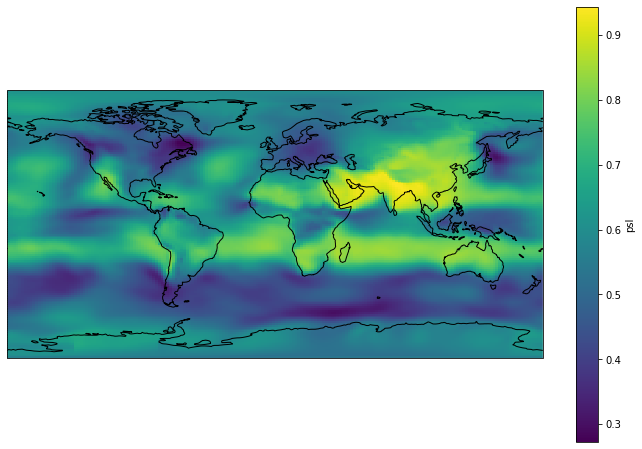

In [19]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
f, axs = plt.subplots(1,1,figsize=(12,8))
p = plt.subplot(111, projection=ccrs.PlateCarree())
p = corr.plot(transform=ccrs.PlateCarree())
p.axes.coastlines()

### Close the client

Before moving on to the next exercise, make sure to close your client or stop this kernel.

In [21]:
client.close()

## Reference

https://examples.dask.org/xarray.html